## Пример для хакатона осеннего семестра первого курса магистратуры "Инженерия машинного обучения"

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл->Сохранить копию на диске...). Свою копию вы сможете изменять и запускать.

Не забудьте включить GPU (Среда выполнения->Сменить среду выполнения->Аппаратный ускоритель->GPU)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

## Загружаем данные

Описание датасета: 
В датасете представлены набор изображений БПЛА и птиц в полете

In [ ]:
!wget https://www.dropbox.com/s/zbrk0twsfytmkhc/train.zip?dl=0  -O train.zip

--2023-01-20 01:06:05--  https://www.dropbox.com/s/zbrk0twsfytmkhc/train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zbrk0twsfytmkhc/train.zip [following]
--2023-01-20 01:06:05--  https://www.dropbox.com/s/raw/zbrk0twsfytmkhc/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc54ad6dda8965445f8494f79f48.dl.dropboxusercontent.com/cd/0/inline/B05LYEK1Z80ld675TUtXV_hcobICl3vJxXgvrFIx3Vy0e2c3O3HZU2gQKcR1888pNzpWZmWMmqa3mFLWh8S808x3Yzm_-xpUcZI-W6wC4yCg3mrn5zcv-CJ1r95x1BBrtJc8xaoQ04itT8op8C-zlqKrigq237-4hucVMKL8H79CHg/file# [following]
--2023-01-20 01:06:06--  https://uc54ad6dda8965445f8494f79f48.dl.dropboxusercontent.com/cd/0/inline/B05LYEK1Z80ld675TUtXV_hcobICl3vJxXgvrFIx3Vy0e2c3O3HZU2gQKcR1888pNzpWZmWMmqa3mFLWh8S8

In [ ]:
!wget https://www.dropbox.com/s/8yi3m5261sk1tkh/test.zip?dl=0 -O test.zip

--2023-01-20 01:06:12--  https://www.dropbox.com/s/8yi3m5261sk1tkh/test.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8yi3m5261sk1tkh/test.zip [following]
--2023-01-20 01:06:12--  https://www.dropbox.com/s/raw/8yi3m5261sk1tkh/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3da922fb0c7ecccf47238091e3.dl.dropboxusercontent.com/cd/0/inline/B040zcpSrFxAQZyopM73rS_C9q0JpCkTpqWd6gD187pP9Cq6UmuFn_bXUUQ_5A_UT9bTiy8VhcmmI3CDUVIyqXhITFSxjWeQuD4gutWvi3pSKhULMbelPnl8QN_atJacVGd_2faR1128aufoBC2YrskciJqhv8ilpYEKO5Epdi0lIQ/file# [following]
--2023-01-20 01:06:13--  https://uc3da922fb0c7ecccf47238091e3.dl.dropboxusercontent.com/cd/0/inline/B040zcpSrFxAQZyopM73rS_C9q0JpCkTpqWd6gD187pP9Cq6UmuFn_bXUUQ_5A_UT9bTiy8VhcmmI3CDUVIyqXh

In [ ]:
!ls

sample_data  test.zip  train.zip


In [ ]:
!unzip -q train.zip

In [ ]:
!ls train

bird  copter


In [ ]:
!unzip -q test.zip

In [ ]:
!ls test

bird  copter


Смотрим примеры картинок

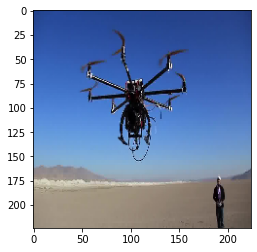

In [ ]:
img_path = 'train/copter/copter1.JPEG'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

## Создаем наборы данных

Набор данных для обучения

In [ ]:
train_dataset = image_dataset_from_directory('train',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 2488 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

In [ ]:
class_names

['bird', 'copter']

Набор данных для тестирования

In [ ]:
test_dataset = image_dataset_from_directory('test',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 359 files belonging to 2 classes.


## Создаем составную нейронную сеть

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = layers.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# Для задачи с двумя классами изображений
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
# Для задачи с несколькими классами изображений
# num_classes = 3 # Задаем количество классов
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

16705208/16705208 [==============================] - 0s 0us/step


Компилируем составную нейронную сеть

In [ ]:
# Для задачи с двумя классами изображений
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
# Для задачи с несколькими классами изображений
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])

## Обучаем сеть

In [ ]:
history = model.fit(train_dataset,
                    epochs=10)
print(train_dataset)

Epoch 1/10


20/20 [==============================] - 70s 3s/step - loss: 0.5731 - accuracy: 0.7150
Epoch 2/10
20/20 [==============================] - 49s 2s/step - loss: 0.2453 - accuracy: 0.9035
Epoch 3/10
20/20 [==============================] - 51s 2s/step - loss: 0.1646 - accuracy: 0.9389
Epoch 4/10
20/20 [==============================] - 49s 2s/step - loss: 0.1412 - accuracy: 0.9482
Epoch 5/10
20/20 [==============================] - 50s 2s/step - loss: 0.1143 - accuracy: 0.9626
Epoch 6/10
20/20 [==============================] - 51s 2s/step - loss: 0.1089 - accuracy: 0.9650
Epoch 7/10
20/20 [==============================] - 49s 2s/step - loss: 0.0981 - accuracy: 0.9662
Epoch 8/10
20/20 [==============================] - 49s 2s/step - loss: 0.0862 - accuracy: 0.9699
Epoch 9/10
20/20 [==============================] - 49s 2s/step - loss: 0.0841 - accuracy: 0.9739
Epoch 10/10
20/20 [==============================] - 48s 2s/step - loss: 0.0706 - accuracy: 0.9779
<BatchDataset element_spec=(Te

Проверяем качество обучения на тестовом наборе данных


In [ ]:
scores = model.evaluate(test_dataset, verbose=1)

3/3 [==============================] - 5s 713ms/step - loss: 0.1735 - accuracy: 0.9387


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 93.8719


## Использование нейронной сети для распознавания изображений

Вспоминаем номера классов

In [ ]:
class_names

['bird', 'copter']

Загружаем изображение из файла

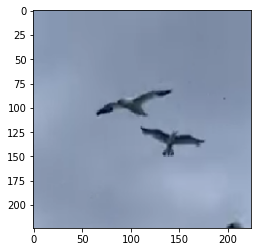

In [ ]:
img_path = '/content/test/bird/2023-01-17_23-06_3.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [ ]:
prediction = model.predict(x)

1/1 [==============================] - 1s 1s/step


Печатаем результаты распознавания

In [ ]:
prediction

array([[0.30759728]], dtype=float32)